# Libs

In [1]:
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import os
import glob

import tqdm

import re

import warnings
warnings.filterwarnings("ignore")

# DataJungle

In [15]:
path_to_images = glob.glob("../data/car/images/*.png")
path_to_masks = glob.glob("../data/car/masks/*.png")
assert len(path_to_masks) == len(path_to_images), "number of images and masks should coinside"

## SmartResize

The eproblem now is that images have different shapes. \
Simple reshaping will also change car's shap and might result in misclassification. \
A correct way of doing it is zooming with padding

In [19]:
unique_img_shape = []
for img_path in path_to_images:
    img = cv2.imread(img_path)
    if img.shape not in unique_img_shape:
        unique_img_shape.append(img.shape)
print(len(unique_img_shape), " inuque image shape were detected.")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


115  inuque image shape were detected.


In [21]:
# does image reshaping changes a car property
# like sedan into a jeep
# Let us look at 3 cares with different shapes
unique_img_shape = []
for i, img_path in enumerate(path_to_images):
    img = cv2.imread(img_path)
    if img.shape not in unique_img_shape:
        print(i, img_path)
    if i==4:
        break

0 ../data/car/images/IMG_20201123_143129__01.png
1 ../data/car/images/IMG_20201123_132724.png
2 ../data/car/images/driver-clipart-horsepower-sports-car-side-view-png-transparent-side-car-png-880_295.png
3 ../data/car/images/IMG_20201123_142958__01.png
4 ../data/car/images/IMG_20201123_143532.png


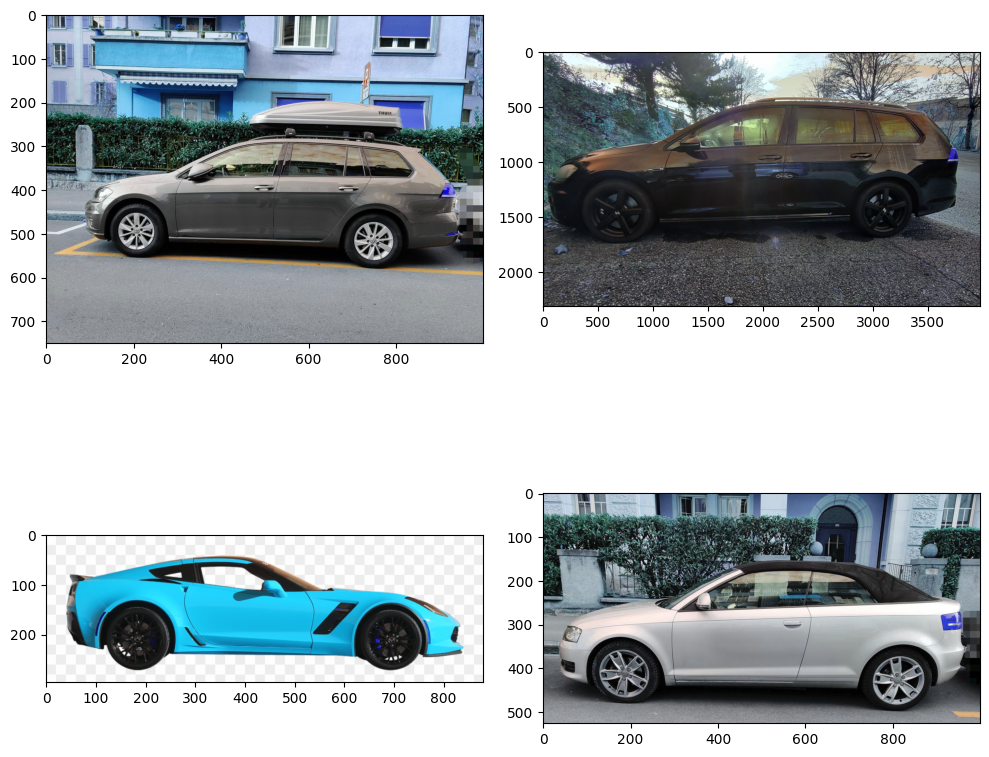

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for idx, image_path in enumerate(path_to_images):
    img = cv2.imread(image_path)
    axes[idx].imshow(img)
    if idx == 3:
        break

plt.tight_layout()
plt.show()

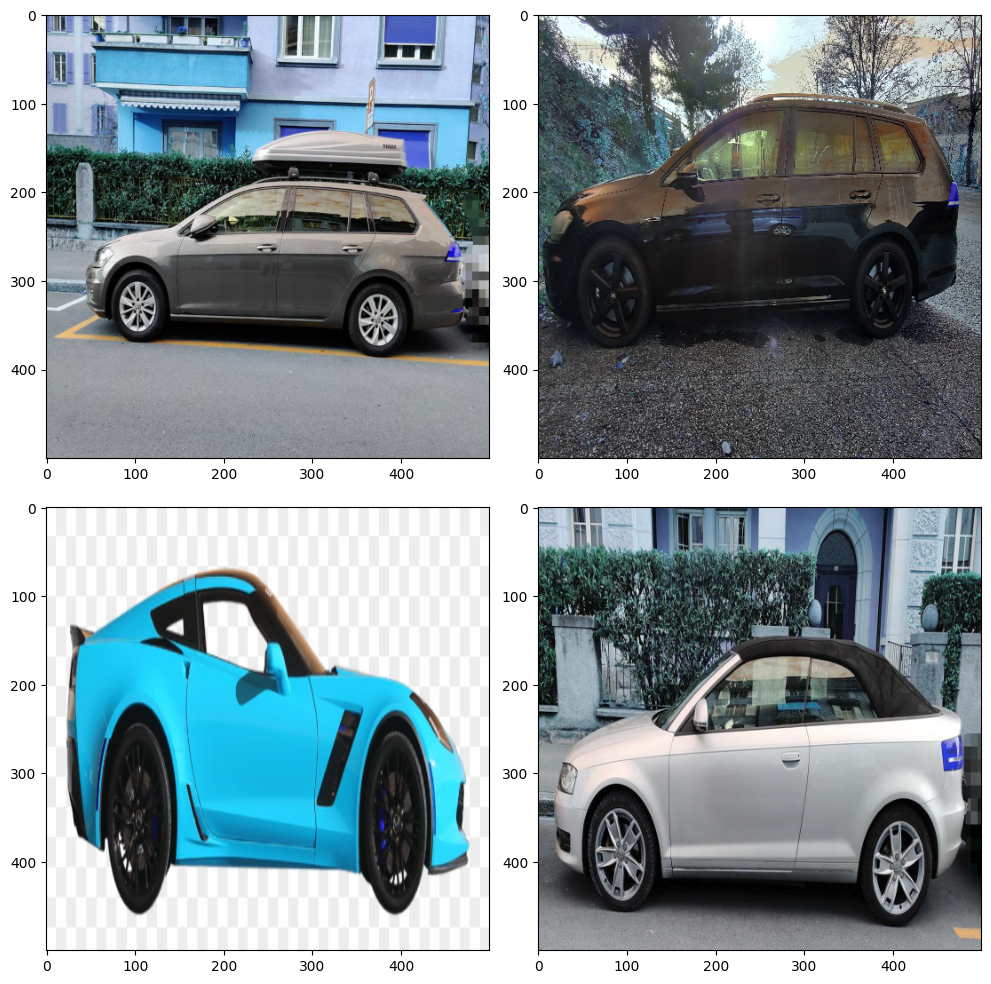

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for idx, image_path in enumerate(path_to_images):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (500, 500))
    axes[idx].imshow(img)
    if idx == 3:
        break

plt.tight_layout()
plt.show()

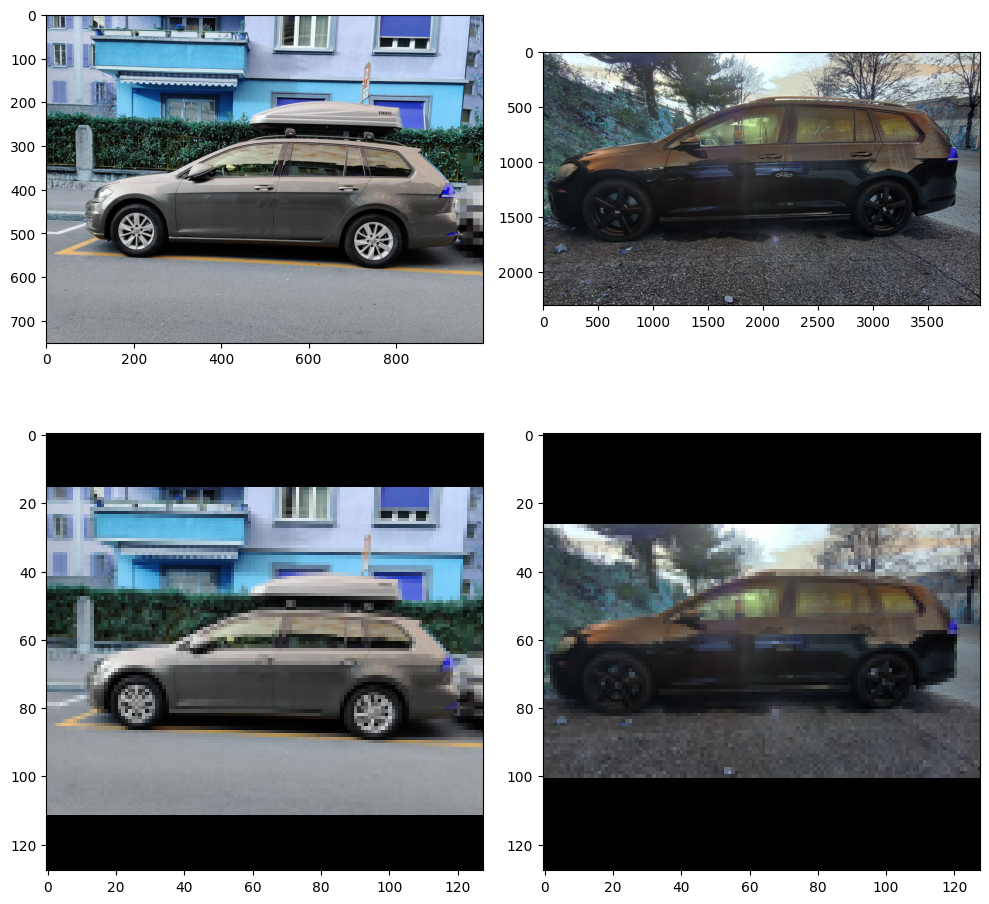

In [27]:
def smart_resize(img: np.array,
                  target_size: int = 128,
                  channel: int = 3):
    """
    Description
    -------
    Resize an image to squeeze into a template; \
    It should be used to resize images to a shape suitable \
    for neaural a neural network, \
    but preserving all the proportions of an object on an image
    
    Parameters
    -------
    img (ndarra): an image
    target_size (int): a size of an expected template
    
    Return
    -------
    tamplate (ndarray): resized image
    """
    height, width = img.shape[:2]
    scale = min(target_size / width, target_size / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    resized_image = cv2.resize(img,
                               (new_width, new_height),
                               interpolation=cv2.INTER_AREA)
    
    tamplate = np.zeros((target_size, target_size, channel),
                        dtype=np.uint8)
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2
    
    tamplate[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image
    
    return tamplate

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
img = cv2.imread(path_to_images[0])
scaled_img = smart_resize(img)
axes = axes.ravel()

for idx, image_path in enumerate(path_to_images):
    img = cv2.imread(image_path)
    scaled_img = smart_resize(img, target_size=128, channel=3)
    axes[idx].imshow(img)
    axes[idx+2].imshow(scaled_img)
    if idx == 1:
        break

plt.tight_layout()
plt.show()

## Dataloader

In [29]:
class SmartDataset(tf.data.Dataset):

    def _generator(img_paths, target_size):
        pattern = r'(/images/)(img_)'
        replacement = r'/masks/seg_'
        for img_path in img_paths:
            if isinstance(img_path, bytes):
                img_path = img_path.decode('utf-8')
            mask_path = re.sub(pattern, replacement, img_path)
            try:
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path)
                img = smart_resize(img, target_size=target_size, channel=3)
                mask = smart_resize(mask, target_size=target_size, channel=3)
            except:
                print(mask_path, " is not found")
            img = tf.cast(img, tf.float32) / 255.0
            mask = tf.cast(mask, tf.float32)
            yield img[:,:,0:1], mask[:,:,0:1]  # sliceing is not a solution

    def __new__(cls,
                img_dir: str,
                first_img: int = 0,
                last_img: int = 32,
                target_size = 128
                ):
        img_paths = glob.glob(f"{img_dir}/*.png")[first_img:last_img]
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=(
                tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)),
            args=(img_paths, target_size)
        )

In [31]:
dataset = SmartDataset(img_dir="../data/clothing/images",
                       target_size=128)

for images, masks in dataset:
    images, masks = images, masks
    break

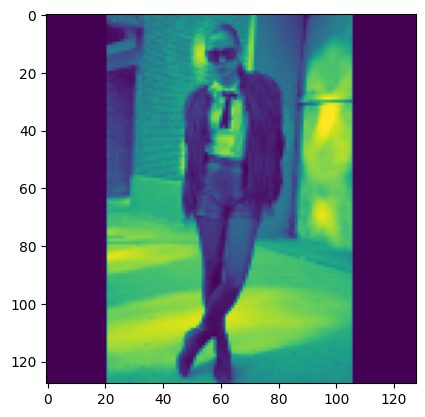

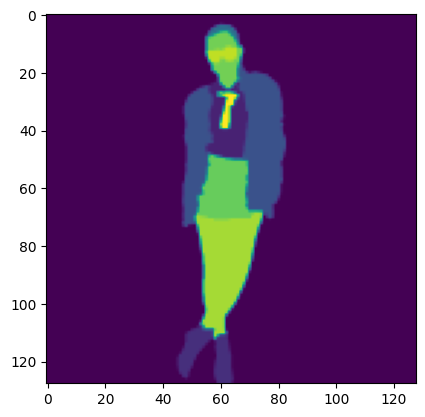

In [33]:
plt.imshow(images.numpy())
plt.show()
plt.imshow(masks.numpy())

In [39]:
def create_dataloader(img_dir,
                      target_size=128,
                      batch_size=32,
                      shuffle=False,
                      first_img: int = 0,
                      last_img: int = 32):
    """
    Creates a dataloader from the custom dataset.

    Parameters
    -------
    - image_dir: Path to the directory containing images.
    - masks_dir: Path to the directory containing masks.
    - target_size: Tuple (width, height) for resizing the images and masks.
    - batch_size: The size of the batches.
    - shuffle: Whether to shuffle the dataset.

    Returns
    -------
    - A tf.data.Dataset object.
    """
    dataset = SmartDataset(img_dir=img_dir,
                           target_size = target_size,
                           first_img=first_img, last_img=last_img)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(glob.glob(f"{img_dir}/*.png")))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

dataloader = create_dataloader(img_dir="../data/clothing/images",
                               target_size=256, batch_size=32,
                               first_img=0, last_img=100)

# Iterate through the dataloader
for images, masks in dataloader:
    images, masks = images, masks
    break

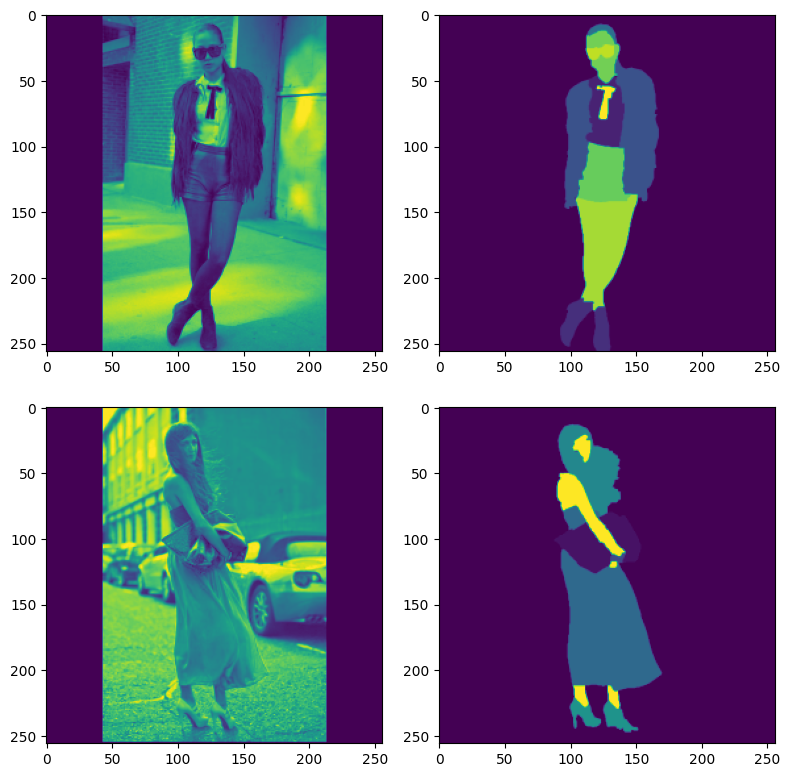

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
axes[0].imshow(images[0].numpy())
axes[1].imshow(masks[0].numpy())
axes[2].imshow(images[1].numpy())
axes[3].imshow(masks[1].numpy())
plt.tight_layout()
plt.show()

## TrainTestVal

In [43]:
BATCH_SIZE = 16
IMG_SIZE = 128

train_dataset = create_dataloader(img_dir="../data/clothing/images",
                                  target_size=128, batch_size=BATCH_SIZE,
                                  first_img=0, last_img=300)
test_dataset = create_dataloader(img_dir="../data/clothing/images",
                                 target_size=128, batch_size=BATCH_SIZE,
                                 first_img=300, last_img=320)
val_dataset = create_dataloader(img_dir="../data/clothing/images",
                                target_size=128, batch_size=BATCH_SIZE,
                                first_img=320, last_img=340)

# Model

## Functionality

The next cell is used to build a custom layer that can inherit weights of another layer

#### TorchVersion

custom Conv2DTranspose layer that takes weights from an Conv2D layer and performs a transpose operation

In [344]:
class CustomConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, dilation=1, groups=1):
        super(CustomConvTranspose2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.output_padding = output_padding
        self.dilation = dilation
        self.groups = groups

    def forward(self, x, weight, bias = None):
        return F.conv_transpose2d(x, weight, bias, self.stride, self.padding, self.output_padding, self.groups, self.dilation)

input_tensor = input_tensor = torch.randn(1, 3, 64, 64)
conv2d_layer = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
maxpool = nn.MaxPool2d(2)
conv2dtranspose_layers = CustomConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=5, padding=7)  # padding?
x = conv2d_layer(input_tensor)
x = maxpool(x)
output_tensor = conv2dtranspose_layers(x, conv2d_layer.weight)

print("Input tensor shape: ", input_tensor.shape)
print("Output tensor shape: ", output_tensor.shape)

Input tensor shape:  torch.Size([1, 3, 64, 64])
Output tensor shape:  torch.Size([1, 3, 64, 64])


A simple custom autoencoder with \
*    encoder: conv2d  -> conv2d \
*   decoder: conv2dT -> conv2dT

In [35]:
class CustomAutoencoderTorch(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.down_l1= nn.Conv2d(3, 64, kernel_size=3)
        self.down_l2 = nn.Conv2d(64, 128, kernel_size=3)
        self.up_l2 = CustomConvTranspose2d(128, 64, kernel_size=3)
        self.up_l1 = CustomConvTranspose2d(64, 3, kernel_size=3)

    def forward(self, x):
        x = self.down_l1(x)
        x = self.down_l2(x)
        x = self.up_l2(x, self.down_l2.weight)
        x = self.up_l1(x, self.down_l1.weight)
        return x

test_model = CustomAutoencoderTorch()

input_tensor = torch.randn(1, 3, 64, 64)
output_tensor = test_model(input_tensor)

print("Input tensor shape: ", input_tensor.shape)
print("Output tensor shape: ", output_tensor.shape)

Input tensor shape:  torch.Size([1, 3, 64, 64])
Output tensor shape:  torch.Size([1, 3, 64, 64])


#### TensorFlowVersion

custom CustomConvTranspose2D layer that takes weights from an Conv2D layer and performs a transpose operation

In [45]:
class CustomConvTranspose2d(keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid', data_format='channels_last', **kwargs):
        super(CustomConvTranspose2d, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = [1, *strides, 1]
        self.padding = padding.upper() if isinstance(padding, str) else padding
        self.data_format = 'NHWC' if data_format == 'channels_last' else 'NCHW'
    
    def call(self, inputs, weights, bias=None):
        # Calculate output shape
        batch_size = tf.shape(inputs)[0]
        height = inputs.shape[1] * self.strides[1]
        width = inputs.shape[2] * self.strides[2]
        output_shape = [batch_size, height, width, self.filters]
        # Perform transposed convolution
        outputs = tf.nn.conv2d_transpose(inputs, weights, output_shape, strides=self.strides, padding=self.padding, data_format=self.data_format)
        # Add bias if provided
        if bias is not None:
            outputs = tf.nn.bias_add(outputs, bias, data_format=self.data_format)
        return outputs

# --------------
input_tensor = tf.random.normal([1, 128, 128, 3])
print("Input shape:", input_tensor.shape)

# ---------------
conv2d_layer = keras.layers.Conv2D(
    filters=128, 
    kernel_size=3, 
    strides=(1, 1), 
    padding='same', 
    data_format='channels_last'
)
custom_conv2d_transpose_layer = CustomConvTranspose2d(
    filters=3,
    kernel_size=3, 
    strides=(1, 1), 
    padding='same', 
    data_format='channels_last'
)

# ---------------
x = conv2d_layer(input_tensor)
output_tensor = custom_conv2d_transpose_layer(x, conv2d_layer.kernel)
print("Output shape (Custom):", output_tensor.shape)

Input shape: (1, 128, 128, 3)
Output shape (Custom): (1, 128, 128, 3)


a simple autoencoder with the custom transpose, maxpool and extrapolation

In [257]:
class CustomAutoencoderTF(keras.layers.Layer):

    def __init__(self, **kwargs):
        super(CustomAutoencoderTF, self).__init__(**kwargs)
        self.maxpool = keras.layers.MaxPooling2D(pool_size=(2, 2)) 
        self. down_l1= keras.layers.Conv2D(64, 3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.down_l2 = keras.layers.Conv2D(128, 3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.down_l3 = keras.layers.Conv2D(256, 3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.down_l4 = keras.layers.Conv2D(512, 3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.down_l5 = keras.layers.Conv2D(1024, 3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.up_l5 = CustomConvTranspose2d(512,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.up_l4 = CustomConvTranspose2d(256,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.up_l3 = CustomConvTranspose2d(128,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.up_l2 = CustomConvTranspose2d(64,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')
        self.up_l1 = CustomConvTranspose2d(3,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')

    def call(self, x):
        x = self.down_l1(x)
        x = self.maxpool(x)
        x = self.down_l2(x)
        x = self.down_l3(x)
        x = self.down_l4(x)
        x = self.down_l5(x)
        x = self.up_l5(x, self.down_l5.kernel)
        x = self.up_l4(x, self.down_l4.kernel)
        x = self.up_l3(x, self.down_l3.kernel)
        x = self.up_l2(x, self.down_l2.kernel)
        x = tf.image.resize(x,
                            [128, 128],
                             method='bilinear')
        x = self.up_l1(x, self.down_l1.kernel)
        return x

test_model = CustomAutoencoderTF()

input_tensor = tf.random.normal([1, 128, 128, 3])
output_tensor = test_model(input_tensor)
print("Input tensor shape: ", input_tensor.shape)
print("Output tensor shape: ", output_tensor.shape)

Input tensor shape:  (1, 128, 128, 3)
Output tensor shape:  (1, 128, 128, 3)


now a unetbloc

In [242]:
x = tf.random.normal([1, 128, 128, 3])
M = tf.random.normal([1, 128, 3, 128])
new = x@M
new.shape

TensorShape([1, 128, 128, 128])

In [221]:
# it just shows how weights are changes after convolution
# the first convolution takes input = [1, 128, 128, channesl]
# and turns it into x = [1, 128, 128, filter].
# But what is more important is that first kernel is instantiated as [3, 3, 3, filter]
# but the secodn one as [3, 3, filter, filter]
class torm(keras.layers.Layer):

    def __init__(self, filter_in, **kwargs):
        super(torm, self).__init__(**kwargs)
        self.layer_1 = keras.layers.Conv2D(filters = filter_in, kernel_size=3, padding="same")
        self.layer_2 = keras.layers.Conv2D(filters = filter_in, kernel_size=3, padding="same")
        self.layer_3 = keras.layers.Conv2D(filters = filter_in, kernel_size=3, padding="same")

    def call(self, x):
        print("X input shape: ", x.shape)
        x = self.layer_1(x)
        print("l1 kernel: \n", self.layer_1.kernel.shape)
        print("X first output shape: ", x.shape)
        x = self.layer_2(x)
        print("l2 kernel: \n", self.layer_2.kernel.shape)
        print("X secodn output shape: ", x.shape)
        x = self.layer_3(x)
        print("l2 kernel: \n", self.layer_3.kernel.shape)
        print("X third output shape: ", x.shape)
        print("-----------+++++--")
        return x

input_tensor = tf.random.normal([1, 128, 128, 3])
to_rm = torm(filter_in=32)
to_rm(input_tensor)
down_l1.weights
print("done")

X input shape:  (1, 128, 128, 3)
l1 kernel: 
 (3, 3, 3, 32)
X first output shape:  (1, 128, 128, 32)
l2 kernel: 
 (3, 3, 32, 32)
X secodn output shape:  (1, 128, 128, 32)
l2 kernel: 
 (3, 3, 32, 32)
X third output shape:  (1, 128, 128, 32)
-----------+++++--
X input shape:  (1, 128, 128, 3)
l1 kernel: 
 (3, 3, 3, 32)
X first output shape:  (1, 128, 128, 32)
l2 kernel: 
 (3, 3, 32, 32)
X secodn output shape:  (1, 128, 128, 32)
l2 kernel: 
 (3, 3, 32, 32)
X third output shape:  (1, 128, 128, 32)
-----------+++++--
done


In [252]:
def down_block(filter_in: int = 64):
    """the problem here is that the frist convolution increases number of features
    then the second one cahnges its shape
    the frist one has weigths (3, 3, channesl, features), while the second already (3, 3, features, features),
    i.e. num of channesl is replaced by num of features.
    
    Solution seems to inherit wheits of the first conv layer. The second should go to the second conv?
    """
    layers = keras.models.Sequential([
        keras.layers.Conv2D(filter_in, 3,
                            strides=(1, 1),
                            padding='same',
                            data_format='channels_last'),
        keras.layers.Conv2D(filter_in, 3,
                            strides=(1, 1),
                            padding='same',
                            data_format='channels_last')
    ])
    return layers


class CustomAutoencoderTF(keras.layers.Layer):

    def __init__(self, **kwargs):
        super(CustomAutoencoderTF, self).__init__(**kwargs)
        self.down_l1= down_block(filter_in=128)
        self.up_l1 = CustomConvTranspose2d(3,
                                           kernel_size=3,
                                           strides=(1, 1),
                                           padding='same',
                                           data_format='channels_last')

    def call(self, x):
        x = self.down_l1(x)
        weights = self.down_l1.weights[0]
        weights2 = self.down_l1.weights[2]
        print(x.shape)
        print(weights.shape, weights2.shape)
        x = self.up_l1(x, weights)
        return x

test_model = CustomAutoencoderTF()

input_tensor = tf.random.normal([1, 128, 128, 3])
output_tensor = test_model(input_tensor)

(1, 128, 128, 128)
(3, 3, 3, 128) (3, 3, 128, 128)
(1, 128, 128, 128)
(3, 3, 3, 128) (3, 3, 128, 128)


The next two blocks are generic cells for down and upsampling used for encoder and decoder

In [15]:
def down_block(filter_in: int = 64,
               conv_kernel: tuple = (3, 3)):
    layers = keras.models.Sequential([
        keras.layers.Conv2D(filters = filter_in,
                            kernel_size=conv_kernel,
                            padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2D(filters = filter_in,
                            kernel_size=conv_kernel,
                            padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(pool_size=(2, 2))
    ])
    return layers

print("Example of a down_block")
layers = down_block()
input_layer = keras.layers.InputLayer(input_shape = (128,128, 1))
model = keras.models.Sequential([input_layer, layers])
print(" input tensor: ", images.shape)
output_tensor = model(images)
print(" output tensor: ", output_tensor.shape)

Example of a down_block
 input tensor:  (4, 128, 128)
 output tensor:  (4, 64, 64, 64)


In [35]:
def up_block(filter_in: int = 128,
             conv_kernel: tuple = (3, 3)):
    layers = keras.models.Sequential([
        keras.layers.Conv2DTranspose(filters=filter_in,
                                     kernel_size=conv_kernel,
                                     strides=(2, 2),
                                     padding='same'),
        keras.layers.Conv2D(filters=filter_in,
                            kernel_size=conv_kernel,
                            padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2D(filters=filter_in,
                            kernel_size=conv_kernel,
                            padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU()
    ])
    return layers

input_layer = keras.layers.InputLayer(input_shape = (128,128, 1))
layers_down = down_block(filter_in=128)
layers_up = up_block(filter_in=128)
top_layer = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')
model = keras.models.Sequential([input_layer, *[layers_down,
                                                layers_up,
                                                top_layer]
])

The follwoing block combines down_block and up_block to create an autoencoder model;

In [367]:
input_layer = keras.layers.InputLayer(input_shape = (228,228, 1))
layers_down1 = down_block(filter_in=64)
layers_down2 = down_block(filter_in=128)
layers_down3 = down_block(filter_in=256)
layers_down4 = down_block(filter_in=512)
layers_down5 = down_block(filter_in=1024)
layers_up5 = up_block(filter_in=512)
layers_up4 = up_block(filter_in=256)
layers_up3 = up_block(filter_in=128)
layers_up2 = up_block(filter_in=64)
layers_up1 = up_block(filter_in=32)
top_layer = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')
model = keras.models.Sequential([input_layer, *[layers_down1,
                                                layers_down2,
                                                layers_down3,
                                                layers_down4,
                                                layers_down5,
                                                layers_up5,
                                                layers_up4,
                                                layers_up3,
                                                layers_up2,
                                                layers_up1,
                                                top_layer]
])
output_tensor = model(images)
print("input tensor: ", images.shape)
print(" output tensor: ", output_tensor.shape)

input tensor:  (32, 128, 128)
 output tensor:  (32, 128, 128, 1)


## Autoencoder

In [376]:
def build_autoencoder(input_shape=(128, 128, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Downsampling path
    down_block1 = down_block(64)(inputs)
    down_block2 = down_block(128)(down_block1)
    down_block3 = down_block(256)(down_block2)
    down_block4 = down_block(512)(down_block3)
    
    # Bottleneck
    bottleneck = down_block(1024)(down_block4)
    
    # Upsampling path
    up_block1 = up_block(512)(bottleneck)
    up_block2 = up_block(256)(up_block1)
    up_block3 = up_block(128)(up_block2)
    up_block4 = up_block(64)(up_block3)
    up_block5 = up_block(32)(up_block4)
    
    # Output layer
    outputs = keras.layers.Conv2D(num_classes,
                                  (1, 1),
                                  activation='sigmoid')(up_block5)
    
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

autoencoder_model = build_autoencoder(input_shape=(256, 256, 1), num_classes=1)
autoencoder_model.summary()

print("-------")
print("Input shape: ", images.shape)
output = autoencoder_model(images)
print("Output shape: ", output.shape)

-------
Input shape:  (32, 256, 256, 1)
Output shape:  (32, 256, 256, 1)


## Unet

In [323]:
def build_unet(input_shape=(128, 128, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Downsampling path
    down_block1 = down_block(64)(inputs)
    down_block2 = down_block(128)(down_block1)
    down_block3 = down_block(256)(down_block2)
    down_block4 = down_block(512)(down_block3)
    
    # Bottleneck
    bottleneck = down_block(1024)(down_block4)
    
    # Upsampling path
    up_block1 = up_block(512)(bottleneck)
    up_block1 = keras.layers.Concatenate()([up_block1, down_block4])
    up_block2 = up_block(256)(up_block1)
    up_block2 = keras.layers.Concatenate()([up_block2, down_block3])
    up_block3 = up_block(128)(up_block2)
    up_block3 = keras.layers.Concatenate()([up_block3, down_block2])
    up_block4 = up_block(128)(up_block3)
    up_block4 = keras.layers.Concatenate()([up_block4, down_block1])
    up_block5 = up_block(128)(up_block4)
    # Output layer
    outputs = keras.layers.Conv2D(num_classes,
                                  (1, 1),
                                  activation='sigmoid')(up_block5)
    
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

unet_model = build_unet(input_shape=(128, 128, 1), num_classes=1)
unet_model.summary()

print("-------")
print("Input shape: ", images.shape)
output = unet_model(images)
print("Output shape: ", output.shape)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_272 (Sequential)    (None, 64, 64, 64)   38080       ['input_33[0][0]']               
                                                                                                  
 sequential_273 (Sequential)    (None, 32, 32, 128)  222464      ['sequential_272[0][0]']         
                                                                                                  
 sequential_274 (Sequential)    (None, 16, 16, 256)  887296      ['sequential_273[0][0]']  

# LossFunction

In [212]:
def dice_loss(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    
    dice = (2. * intersection + epsilon) / (union + epsilon)
    dice_loss = 1 - dice
    
    return tf.reduce_mean(dice_loss)

# Train

## train_fn

In [324]:
def train_fn(model,
             loss_fn,
             dataset,
             optimizer,
             first_step: int = 0,
             epochs: int = 10):
    average_loss = {}
    for epoch in tqdm.tqdm(range(first_step, first_step + epochs)):
        for X, Y in dataset:
            mask = tf.where(Y > 1, tf.ones_like(Y), Y)
            with tf.GradientTape() as tape:
                Y_pred = model(X, training=True)
                Y_pred = tf.squeeze(Y_pred, axis=-1)
                loss = loss_fn(Y_pred, mask)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        average_loss[epoch] = loss.numpy()
        print(f'Epoch {epoch + 1}/{first_step + epochs}, Loss: {average_loss[epoch]:.4f}')
    return average_loss

## train

In [326]:
optim=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

In [348]:
history_unet = {}
history_autoencoder = {}

In [349]:
EPOCHS = 20
h = train_fn(model=autoencoder_model,
             dataset=train_dataset,
             loss_fn=dice_loss,
             optimizer=optim,
             first_step=0,
             epochs=EPOCHS)
history_autoencoder.update(h)

# unet_model.save('unet_cloth.h5')
autoencoder_model.save('autoencoder_model.h5')

  5%|▌         | 1/20 [01:00<19:17, 60.95s/it]

Epoch 1/20, Loss: 0.2735


 10%|█         | 2/20 [01:58<17:44, 59.17s/it]

Epoch 2/20, Loss: 0.2154


 15%|█▌        | 3/20 [02:56<16:36, 58.60s/it]

Epoch 3/20, Loss: 0.1941


 20%|██        | 4/20 [03:54<15:30, 58.13s/it]

Epoch 4/20, Loss: 0.1846


 25%|██▌       | 5/20 [04:52<14:30, 58.02s/it]

Epoch 5/20, Loss: 0.1731


 30%|███       | 6/20 [05:54<13:55, 59.68s/it]

Epoch 6/20, Loss: 0.1551


 35%|███▌      | 7/20 [06:55<12:58, 59.86s/it]

Epoch 7/20, Loss: 0.1478


 40%|████      | 8/20 [07:53<11:52, 59.33s/it]

Epoch 8/20, Loss: 0.1447


 45%|████▌     | 9/20 [08:49<10:43, 58.46s/it]

Epoch 9/20, Loss: 0.1327


 50%|█████     | 10/20 [09:47<09:42, 58.23s/it]

Epoch 10/20, Loss: 0.1295


 55%|█████▌    | 11/20 [10:43<08:38, 57.63s/it]

Epoch 11/20, Loss: 0.1254


 60%|██████    | 12/20 [11:36<07:27, 55.99s/it]

Epoch 12/20, Loss: 0.1228


 65%|██████▌   | 13/20 [12:28<06:23, 54.75s/it]

Epoch 13/20, Loss: 0.1300


 70%|███████   | 14/20 [13:19<05:22, 53.81s/it]

Epoch 14/20, Loss: 0.1181


 75%|███████▌  | 15/20 [14:11<04:25, 53.10s/it]

Epoch 15/20, Loss: 0.1129


 80%|████████  | 16/20 [15:02<03:30, 52.67s/it]

Epoch 16/20, Loss: 0.1165


 85%|████████▌ | 17/20 [15:54<02:37, 52.50s/it]

Epoch 17/20, Loss: 0.1210


 90%|█████████ | 18/20 [16:46<01:44, 52.17s/it]

Epoch 18/20, Loss: 0.1140


 95%|█████████▌| 19/20 [17:37<00:52, 52.01s/it]

Epoch 19/20, Loss: 0.1146


100%|██████████| 20/20 [18:29<00:00, 55.48s/it]

Epoch 20/20, Loss: 0.1140


Text(0, 0.5, 'Loss')

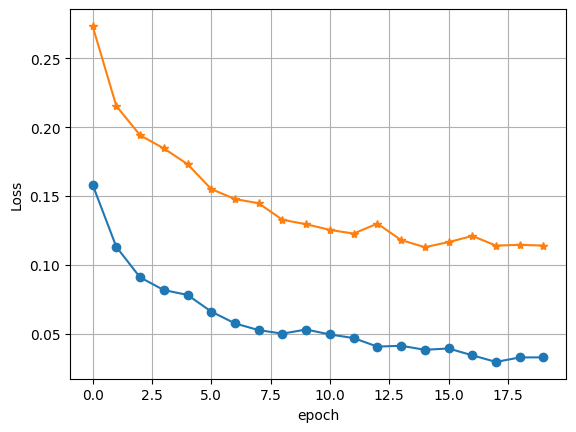

In [350]:
plt.plot(history_unet.keys(),
         history_unet.values(),
         "-o")
plt.plot(history_autoencoder.keys(),
         history_autoencoder.values(),
         "-*")

plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("Loss")

In [353]:
for X, Y in test_dataset:
    mask = tf.where(Y > 1, tf.ones_like(Y), Y)
    Y_pred = unet_model.predict(X)
    # Y_pred = autoencoder_model.predict(X)
    Y_pred = tf.squeeze(Y_pred, axis=-1)
    break

1/1 [==============================] - 2s 2s/step


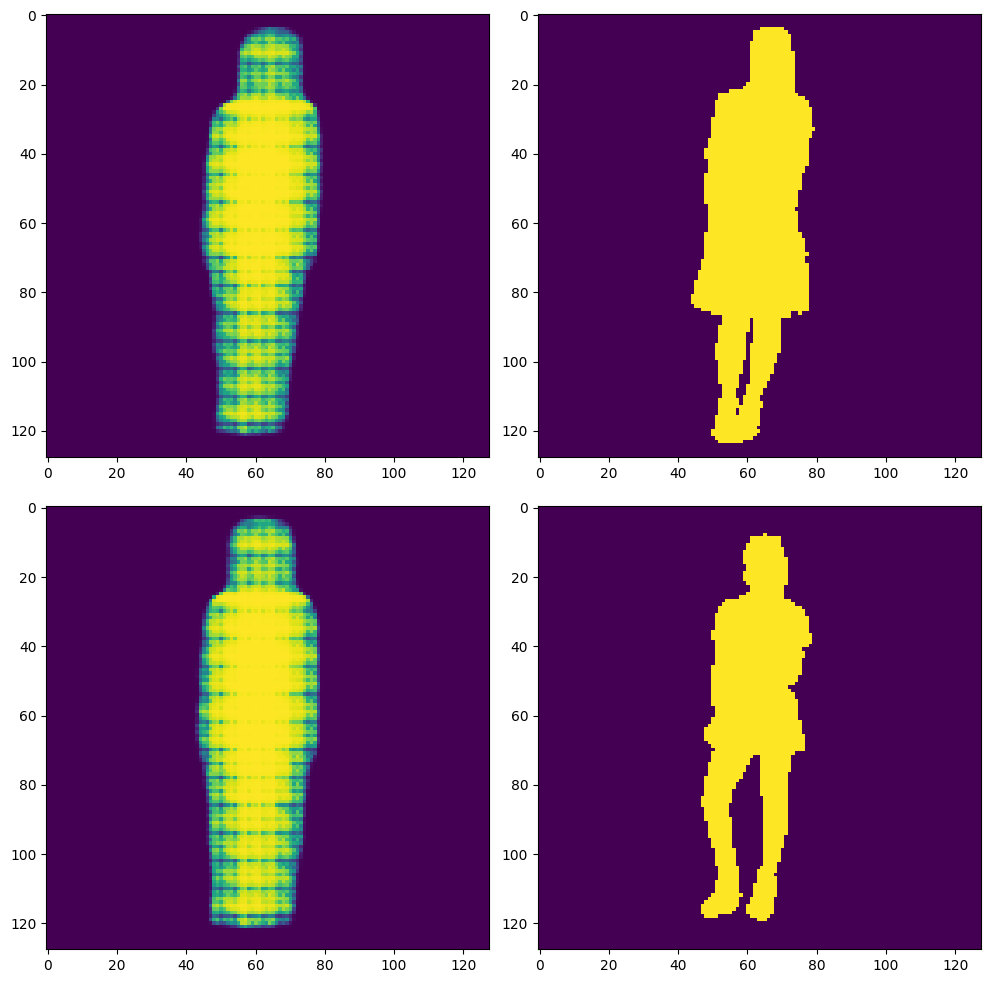

In [352]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

i = 0
axes[0].imshow(Y_pred[i])
axes[1].imshow(mask[i])
axes[2].imshow(Y_pred[i+1])
axes[3].imshow(mask[i+1])

plt.tight_layout()
plt.show()